In [ ]:
using CMBLensing
using CMBLensing: get_ℓ⁴Cℓ
using JLD
using PyPlot
using Parameters
using PyCall
@pyimport seaborn.apionly as sns

In [130]:
rc("xtick",top=true,bottom=true,direction="in",labelsize=12)
rc("ytick",left=true,right=true,direction="in",labelsize=12)
rc("axes",labelsize=16,titlesize=16)
rc("legend",frameon=false,fontsize=12)
rc("figure",figsize=(6.4,4.8))

## Load from CMBLensing

In [2]:
# dat = load("../dat/run2_256_3_teb_r05_lf7_20wauto.jld")

# @unpack T,Θpix,nside,ϕ,f,f̃,d = dat["rundat"]
# @unpack fcur,f̃cur,ϕcur = dat["trace"][end]

# fest,f̃est,ϕest = fcur,f̃cur,ϕcur
# ϕtrue,ftrue,f̃true = ϕ,f,f̃;

In [3]:
dat = load("../dat/run2_1024_3_teb_r05_lf7_30wauto_seed0.jld")

@unpack T,Θpix,nside,Cℓf,Cℓn,ϕ,f,f̃,d = dat["rundat"]
@unpack fcur,f̃cur,ϕcur = dat["trace"][end]
Cℓf̃ = Dict(k=>Cℓf[Symbol("ln_$k")] for (k,v) in Cℓf if Symbol("ln_$k") in keys(Cℓf))

fest,f̃est,ϕest = fcur,f̃cur,ϕcur
ϕtrue,ftrue,f̃true = ϕ,f,f̃;

In [4]:
# t = 2dat["rundat"][:target_lnP]
# (-2dat["trace"][end][:lnP] - t) / sqrt(2t)

In [5]:
t = -2dat["rundat"][:target_lnP]
(-2dat["trace"][end][:lnP1] - t) / sqrt(2t)

-1.7448212f0

## Plotting

In [6]:
import PyPlot: plot

In [7]:
# plotting a real matrix
function plot(m::AbstractMatrix{<:Real}; title=nothing, vlim=nothing, kwargs...)
    m[isinf(m)]=NaN
    ax = sns.heatmap(m; mask=isnan(m), rasterized=true, xticklabels=false, yticklabels=false, 
        vmin=(vlim==nothing?vlim:-vlim),vmax=vlim,square=true, kwargs...)
    title!=nothing && ax[:set_title](title)
    ax
end

plot (generic function with 12 methods)

In [8]:
# plotting a complex matrix 
# we assume its a ~N×2N matrix (like a real FFT), and create a new ~2N×2N matrix
# with the real part on the upper half and the imaginary part mirrored on the
# bottom, with a row of NaN's inbetween to visually separate
function plot(m::AbstractMatrix{Complex{T}}; kwargs...) where {T}
    plot(log10.(abs.([real(m); fill(NaN,size(m,2))'; imag(m[end:-1:1,:])])); kwargs...)
end

plot (generic function with 12 methods)

## $\phi$ figure

In [9]:
using CMBLensing: FlatField

In [143]:
function plot2(f::Field, k, ax; kwargs...)
    im = plot(f[k],ax=ax; kwargs...)
    tk = [reverse(512:-200:0)[1:end-1]; 512:200:1024]
    ax[:set_xticks](tk)
    ax[:set_xticklabels](["$(x)°"for x=-20:10:20])
    ax[:set_yticks](tk)
    ax[:set_yticklabels](["$(x)°"for x=-20:10:20])
    ax[:set_ylabel]("Dec")
    ax[:set_xlabel]("RA")
    ax[:tick_params](axis="both", which="both",length=0)
#     ax[:xaxis][:set_ticks_position]("bottom")
    im
end

plot2 (generic function with 1 method)

In [11]:
using CMBLensing: HP, LP

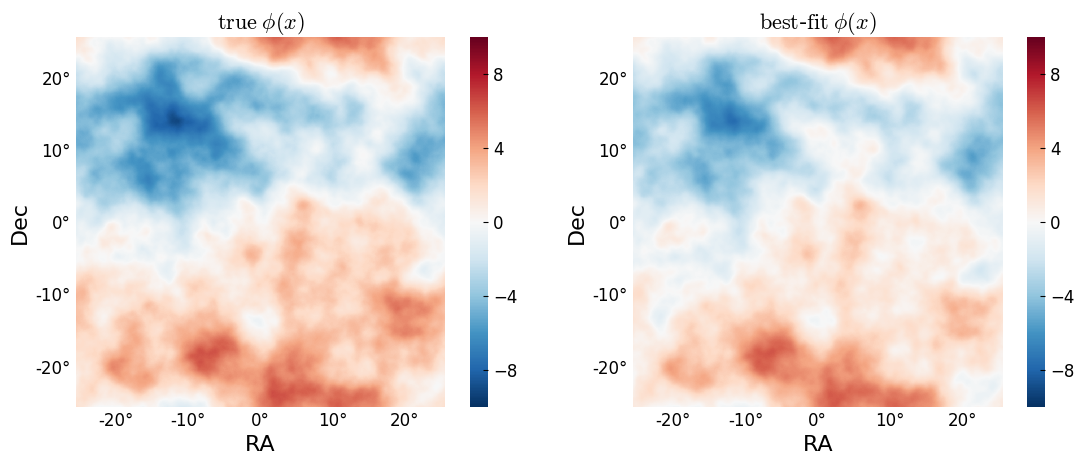

In [144]:
s = 4.8
fig,axs=subplots(nrows=1,ncols=2,figsize=(1.4*2s,1s))
subplots_adjust(wspace=0.15)
vlim = 10
plot2(1e5ϕ,:Tx,axs[1],vlim=vlim,title=raw"${\rm true}\;\phi(x)$")
# plot2(1e5(LP(9,0)*ϕ+HP(9,0)*ϕcur),:Tx,axs[2],vlim=vlim,title=raw"${\rm best}$-${\rm fit}\;\phi(x)$")
plot2(1e5(ϕcur),:Tx,axs[2],vlim=vlim,title=raw"${\rm best}$-${\rm fit}\;\phi(x)$")

savefig("../paper/figs/phiest.pdf",bbox_inches="tight")

## B figure

In [79]:
P=Flat{Θpix,nside}
Cf = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf[k] for k=(:tt,:ee,:bb,:te))...)
Cf̃ = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓf̃[k] for k=(:tt,:ee,:bb,:te))...)
Cn = Cℓ_to_cov(T,P,S0,S2, Cℓf[:ℓ], (Cℓn[k] for k=(:tt,:ee,:bb,:te))...);

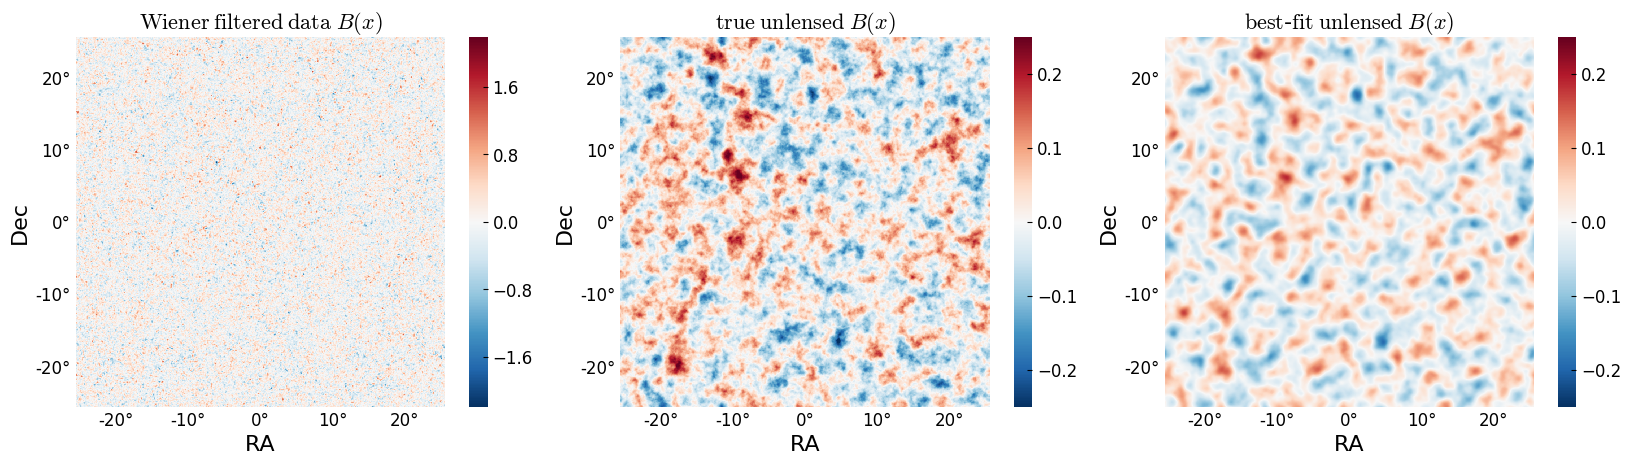

In [265]:
## s = 4
fig, axs = plt[:subplots](nrows=1, ncols=3, figsize=(1.4*3s,1s))
subplots_adjust(wspace=0.15)

plot2(((nan2zero.(𝕎(Cf̃,Cn)*d))),:Bx, axs[1],title=raw"${\rm Wiener\;filtered\;data}\;B(x)$")
# mymat(((nan2zero.(𝕎(Cf,Cn+Cf̃-Cf)*d)))[:Bx], axs[1],title=raw"${\rm Wiener\;filtered\;data}\;B(x)$")
# mymat(d[:Bx],   axs[1],vlim=5,title=raw"${\rm data}\;B(x)$")
plot2(f,:Bx,   axs[2],vlim=0.25,title=raw"${\rm true\;unlensed}\;B(x)$")
plot2(fcur,:Bx,axs[3],vlim=0.25,title=raw"${\rm best}$-${\rm fit\;unlensed}\;B(x)$")

savefig("../paper/figs/Best.pdf",bbox_inches="tight")

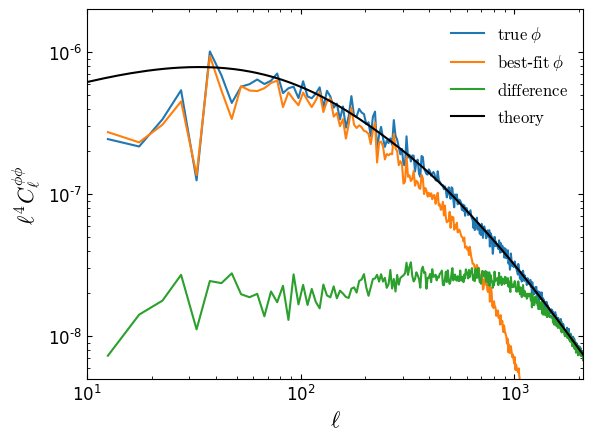

In [263]:
let Δℓ=5,
    ℓedges=10:Δℓ:16000;
    loglog(get_ℓ⁴Cℓ(ϕtrue,Δℓ=Δℓ,ℓedges=ℓedges)..., label=raw"$\rm true \; \phi$")
    loglog(get_ℓ⁴Cℓ(ϕest,Δℓ=Δℓ,ℓedges=ℓedges)...,label=raw"$\rm best$-$\rm fit\; \phi$")
    loglog(get_ℓ⁴Cℓ(ϕest-ϕtrue,Δℓ=Δℓ,ℓedges=ℓedges)..., label=raw"$\rm difference$")
    loglog((@. Cℓf[:ℓ]^2*(Cℓf[:ℓ]+1)^2*Cℓf[:ϕϕ]),"k", label=raw"$\rm theory$")
    legend(loc="upper right")
    ylim(5e-9,2e-6)
#     ylim(1e-5,1e-3)
end
xlim(10,2100)
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell^{\phi \phi}$")

savefig("../paper/figs/phispec.pdf",bbox_inches="tight")

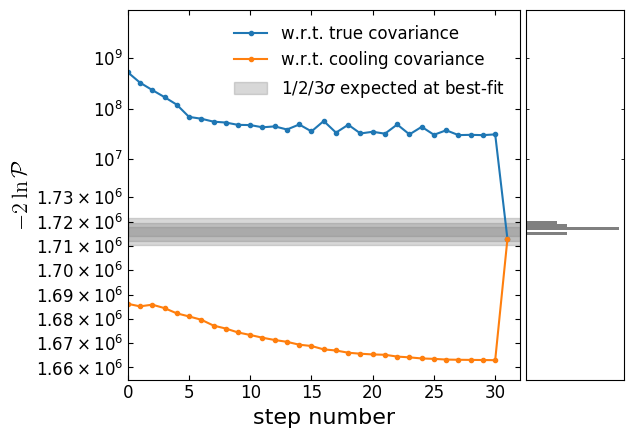

In [278]:
rc("mathtext",fontset="dejavusans")

g = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
ax = subplot(g[1])

plot(-2getindex.(dat["trace"],:lnP1),".-",label=raw"w.r.t. true covariance")
plot(-2getindex.(dat["trace"],:lnPw),".-",label=raw"w.r.t. cooling covariance")

t = -2mean(load("../dat/target_lnPs_1024_3_teb_lmaxdat3000.jld","target_lnPs"))
for y=1:3
    fill_between([0,length(dat["trace"])], (fill(t+y*x*sqrt(2t),2) for x=[1,-1])..., 
            color="gray", alpha=0.3, label=y==1?raw"1/2/3$\sigma$ expected at best-fit":nothing)
end

legend(loc="upper right")

xlabel("step number")
ylabel(raw"$-2\ln\mathcal{P}$",usetex=true)


yscale("symlog",linthreshy=1.73e6,linscaley=75)
ylim(1.655e6,9e9)
xlim(0,32)
ax[:set_yticks]([(1.66:0.01:1.73)*1e6;1e7;1e8;1e9])
ax[:set_yticklabels]([[@sprintf("\$%.2f \\times 10^6\$",x) for x=(1.66:0.01:1.73)];["\$10^$i\$" for i=7:9]])
ax[:set_xticks](0:5:31)

ax = subplot(g[2])
χ²s = -2load("../dat/lnPs.jld","lnPs")
ax[:hist](χ²s, bins=5, orientation="horizontal", color="gray")#plt[:rcParams]["axes.prop_cycle"][:by_key]()["color"][3])
yscale("symlog",linthreshy=1.73e6,linscaley=75)
ylim(1.655e6,9e9)
ax[:set_yticks]([])
ax[:set_xticks]([])

subplots_adjust(wspace=0.025)

savefig("../paper/figs/lnPtrace.pdf",bbox_inches="tight")